# Decision Trees, Ensemble Estimators and Random Forest Regression

Like in 4a), we will be working on the [Cement Strength Dataset](https://www.kaggle.com/pavanraj159/concrete-compressive-strength-data-set).
For this notebook, the task will be to train a grid search, first for a Decision Tree, and then for a Random Forest.

In [1]:
# load and show dataset

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv('concrete_strength.csv')
data

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


**Task:** Split the data into training and testing set, choose a sensible split. Use the random_state 350 to 

In [3]:
X = data.drop(columns=['csMPa'])
y = data['csMPa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=350)

Now, we want to train a Decision Tree Regressor. A Decision Tree tries to infer a set if->then/else rules from the data it is given in order to best approximate it. 

**Task:** Build Decision Tree Regressor. Run a grid search to iterate over _min_samples_split_ (example values: 2, 5, 10), _max_features_ (example values: 'sqrt','log2') and _criterion_ (example values: 'mse', 'friedman_mse', 'mae'). Familiarize yourself with [what these parameters mean](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

_Remark_: Like in 4a we again also transform our dependent variable _csMPa_. This serves more as a demonatration and should not significantly influence the perfomrance. But feel free to apply different transformations or no transformation at all!
We also applied cost-complexity pruning here. By deflaur sklearn does not post prune a tree. Have a look into the documentation [Post Pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html). We follow the idea to first retrieve potential thresholds $\alpha$ by calling the `.cost_complexity_pruning_path` of the tree.As the hight amount of $\alpha$ candidates would lead to a complex gridsearch we use a very sparese subset for the demo. You can turn this off by uncommenting the line `#del(param_grid['regressor__tree__ccp_alpha'])`. This will remove the ccp parameter list from the _param_grid_.

In [4]:
# gridsearch decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor

sc = StandardScaler()
dtr = DecisionTreeRegressor(splitter='best',random_state=42)

msp = [2,5,10]
mfeats = [X_train.shape[1],'sqrt','log2']
crit = ['mse','friedman_mse','mae']


### Validation
cval = KFold(n_splits=10, random_state=42)

pipe = Pipeline([('scaler',sc),('tree', dtr)])
model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
path = model.regressor['tree'].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp = ccp_alphas[4:-2:32]

param_grid = {'regressor__tree__min_samples_split': msp,
              'regressor__tree__max_features': mfeats,
              'regressor__tree__criterion': crit,
             'regressor__tree__ccp_alpha': ccp}
#del(param_grid['regressor__tree__ccp_alpha'])             
search = GridSearchCV(model, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
print(search.best_params_)
print('Depth: ' + str(search.best_estimator_.regressor_['tree'].get_depth()) + ' number of leaves: ' +  str(search.best_estimator_.regressor_['tree'].get_n_leaves()))

/Users/ppp/miniconda2/envs/dlmm-cpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameter RMSE=6.790):
{'regressor__tree__ccp_alpha': 0.0001416450777211726, 'regressor__tree__criterion': 'friedman_mse', 'regressor__tree__max_features': 8, 'regressor__tree__min_samples_split': 2}
Depth: 13 number of leaves: 198


_Remark_: We can use the [graphviz](https://graphviz.org/) package to plot our tree. In our case this leads (even with pruning) to a huuuuge plot.

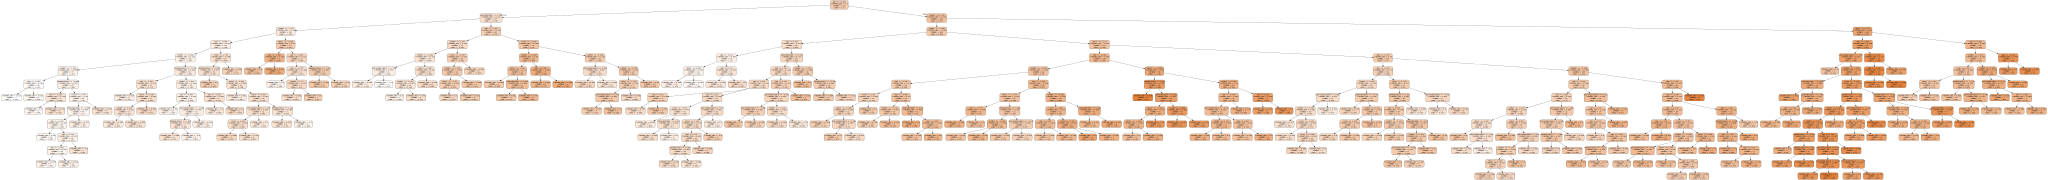

In [5]:
from sklearn import tree
best_tree_estimator = search.best_estimator_
import graphviz 
dot_data = tree.export_graphviz(best_tree_estimator.regressor_['tree'], out_file=None,
                               feature_names=X_train.columns,filled=True, rounded=True) 
graph = graphviz.Source(dot_data) 
graph

Illustrate the results for both the training and testing set the test set for the best estimator.

RMSE training fit: 2.181
R2 training fit: 0.984 
RMSE prediction: 6.015
R2 prediction: 0.846 


Text(0.5, 0, 'Residuals')

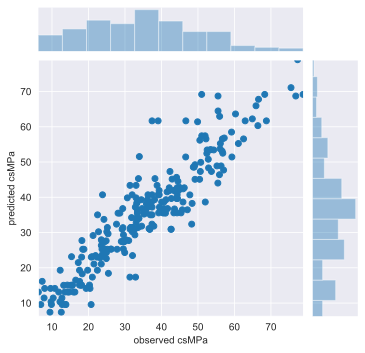

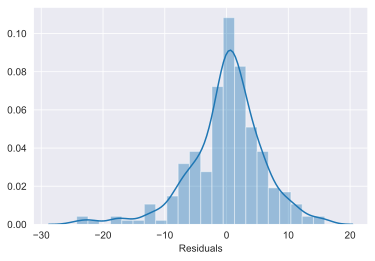

In [6]:
y_pred_train = best_tree_estimator.predict(X_train)
y_pred_test = best_tree_estimator.predict(X_test)

print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

minlim = y_test.min()
maxlim = y_test.max()
# predicted/actual plot for test set
ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
ax.ax_joint.set_xlabel('observed csMPa')
ax.ax_joint.set_ylabel('predicted csMPa')
plt.figure()
sns.distplot(y_test-y_pred_test)
plt.xlabel('Residuals')

__Task:__ What stands out as an issue with the Decision Tree model?

## From Tree to Forest

In the last subtask, you probably noticed that the training error was far smaller than the testing error. Tree models - in general - are prone to overfitting. This is why, in real-world, often Random Forests are used. Random forests is an "ensemble" of a large number of Trees, where each one is given a subset of the samples and/or features in order to create an "expert tree" that is fit to a subportion of the dataset. In the end, the prediction of all trees is averaged to increase generalization.

**Task:** Define a model using a Random Forest Regressor. Iterate over the parameters "n_estimators" (example: 100-2000) and "max_features" (2,5, num_features). Familiarize yourself with [what these parameters mean](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [7]:
# gridsearch random forest
from sklearn.ensemble import RandomForestRegressor

sc = StandardScaler()
rfr = RandomForestRegressor()
gsN = [100,500,1000,2000]
gsK = np.arange(1,X_train.shape[1],2)

### Validation
cval = KFold(n_splits=10, random_state=42)


pipe = Pipeline([('scaler',sc),('forest', rfr)])
model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
param_grid = {'regressor__forest__n_estimators': gsN,
              'regressor__forest__max_features': gsK}

search = GridSearchCV(model, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
print(search.best_params_)


/Users/ppp/miniconda2/envs/dlmm-cpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameter RMSE=5.127):
{'regressor__forest__max_features': 5, 'regressor__forest__n_estimators': 500}


Illustrate the results for both the training and testing set the test set for the best estimator. Compare the results to the Decision Tree. 

RMSE training fit: 2.056
R2 training fit: 0.986 
RMSE prediction: 4.747
R2 prediction: 0.904 


Text(0.5, 0, 'Residuals')

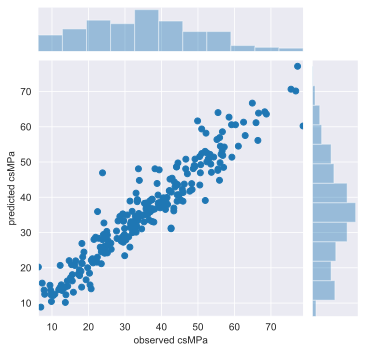

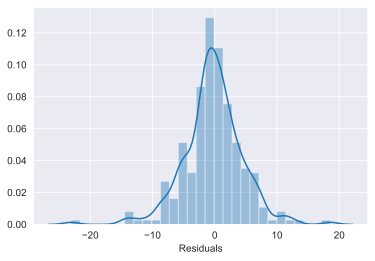

In [8]:
best_forest_estimator = search.best_estimator_

y_pred_train = best_forest_estimator.predict(X_train)
y_pred_test = best_forest_estimator.predict(X_test)

print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

minlim = y_test.min()
maxlim = y_test.max()
# predicted/actual plot for test set
ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
ax.ax_joint.set_xlabel('observed csMPa')
ax.ax_joint.set_ylabel('predicted csMPa')
plt.figure()
sns.distplot(y_test-y_pred_test)
plt.xlabel('Residuals')

_Remark_: We can access each single tree on our forest as shown below. You can see that the trees are not pruned (ccp_alhpa=0). Give it a try by yourself - does pruning improve the predictive power allthough we use an ensemble?

_Remark_: We can access each single tree on our forest as shown below. You can see that the trees are not pruned (ccp_alhpa=0). Give it a try by yourself - does pruning improve the predictive power allthough we use an ensemble

In [9]:
best_forest_estimator.regressor_['forest'].estimators_[:3]

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=811550457, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1988076707, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0

An interesting "free candy" of Trees is the fact that you can rank importantance of each feature. This is given by the `estimator.feature_importances_` attribute in sklearn.

**Task:** For your Random Forest resulting from the grid search plot the resulting feature importance rankings!

_Remark_: A RandomForestRegressor-object holds the attribute `.feature_importances_` to give you an impurity-based ranking of the features. If you like to have more statistics on the importance, you can retrieve the importances of all trees in the forest and then calculate the standard deviation.

Feature ranking:
1. age (0.338851)
2. cement (0.297924)
3. water (0.114012)
4. superplasticizer (0.072201)
5. slag (0.067294)
6. fineaggregate (0.043174)
7. flyash (0.033649)
8. coarseaggregate (0.032894)


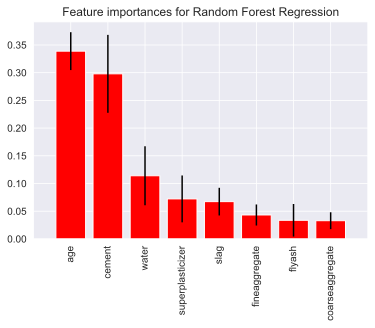

In [10]:
#best_forest_estimator.fit(X_train, y_train)
forest = best_forest_estimator.regressor_['forest']

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, data.drop('csMPa',axis=1).columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances for Random Forest Regression")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), data.drop('csMPa',axis=1).columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Sometimes it might take a while to train a model. If you want to use a trained model later on you can save it using pickle ([SciKit Learn Docs: Model Persistence](https://scikit-learn.org/stable/modules/model_persistence.html))

__Task__: Save your trained Tree and Forest models using pickle!

In [11]:
import pickle
pkl_filename = "decision_tree_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_tree_estimator, file)

pkl_filename = "random_forest_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_forest_estimator, file)

An important consideration is how much your choice of training and testing set affects the feature importance, and thus the stability of our estimator. For this, we can use an outer cross validation (nested cv) to execute the grid search multiple times and observe the feature importance rankings for each fold.

**Task:** Split the dataset using a 3-Fold split. For each iteration, execute the grid search from the last task. With the best hyperparameters, find and plot the feature importances for the training set (consisting of two folds each).

For fold: 1
Best parameter RMSE=7.876):
{'regressor__forest__max_features': 5, 'regressor__forest__n_estimators': 1000}
Feature ranking:
1. age (0.350375)
2. cement (0.280596)
3. water (0.114240)
4. slag (0.070378)
5. superplasticizer (0.068919)
6. fineaggregate (0.047378)
7. coarseaggregate (0.035011)
8. flyash (0.033104)


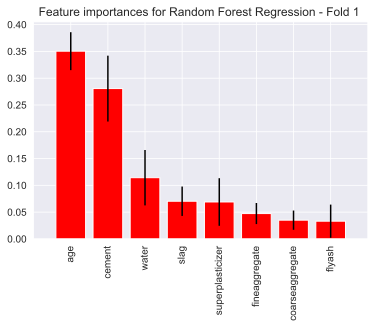

For fold: 2
Best parameter RMSE=7.320):
{'regressor__forest__max_features': 7, 'regressor__forest__n_estimators': 100}
Feature ranking:
1. age (0.326451)
2. cement (0.316755)
3. water (0.133847)
4. slag (0.069132)
5. superplasticizer (0.051968)
6. fineaggregate (0.044467)
7. coarseaggregate (0.032441)
8. flyash (0.024941)


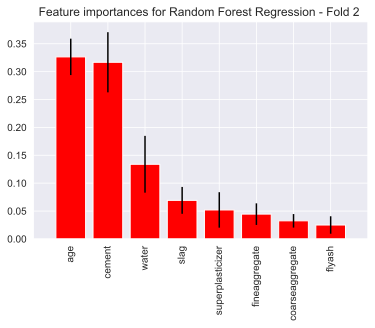

For fold: 3


In [ ]:
kf = KFold(n_splits=3, shuffle=True)

sc = StandardScaler()
rfr = RandomForestRegressor()
gsN = [100,500,1000,2000]
gsK = np.arange(1,X_train.shape[1],2)

i = 0
for train_index, test_index in kf.split(X):
    
    # split into training and testing data
    X_train = X.iloc[train_index,:]
    y_train = y[train_index]
    
    # not needed but we still do it for completeness
    X_test = X.iloc[test_index,:]
    y_test = y[test_index]
    
    i = i+1
    print("For fold: %s" %(i))
    
    pipe = Pipeline([('scaler',sc),('forest', rfr)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    param_grid = {'regressor__forest__n_estimators': gsN,
                  'regressor__forest__max_features': gsK}
    search = GridSearchCV(model, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(X_train, y_train)
    print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
    print(search.best_params_)
    
    
    best_forest_estimator = search.best_estimator_
    best_forest_estimator.fit(X_train, y_train)

    # retrieve random forest estimator object from the transformedTargetRegressor
    forest = best_forest_estimator.regressor_['forest']

    importances = forest.feature_importances_
    
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %s (%f)" % (f + 1, data.drop('csMPa',axis=1).columns[indices[f]], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances for Random Forest Regression - Fold %s " %(i))
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), data.drop('csMPa',axis=1).columns[indices],rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()